In [1]:
#%matplotlib inline
from scipy import interpolate, ndimage
from copy import deepcopy

In [2]:
from scipy import interpolate, ndimage
from copy import deepcopy

In [2]:
import re
import numpy

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    #print filename
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [226]:
def profile2D(image, xaxis, yaxis):
    fig, ax = plt.subplots(2,2,
                           figsize = (12,12),
                           sharey='row',sharex='col',
                           gridspec_kw={'width_ratios':[1,4],
                                        'height_ratios':[4,1]})
    fig.delaxes(ax[1,0])

    xmax = image.max(axis=0)
    ax[1,1].plot(xaxis,xmax)

    ymax = image.max(axis=1)
    ax[0,0].plot(ymax, yaxis[::-1])

    ax[0,1].imshow(image, plt.cm.gray, 
                   aspect='auto',
                   extent = [0, image_dimensions[1], 0, image_dimensions[0]])

    plt.subplots_adjust(wspace=0, hspace=0)

    ax[0,0].set_ylabel('y (mm)')
    ax[1,1].set_xlabel('x (mm)')
    return fig

def profileContour(image, xaxis, yaxis):
    fig = plt.figure( figsize = (12,9))
    ax = fig.add_subplot(111)
    
    levels = np.linspace(noise, image.max(), 10)

    #### 
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = levels
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N) 
    #######
    
    c = ax.imshow(image, cmap=cmap, 
                  norm=norm, 
                  aspect='auto',
                  extent = [0, image_dimensions[1], 0, image_dimensions[0]])
    
    cf = ax.contour(xaxis, yaxis[::-1], image, 
                    levels = levels,
                    colors = 'white',
                    alpha = 0.5)

    plt.colorbar(c)
    
    plt.ylim(3, 7)
    plt.xlim(1.5, 8.5)
    
    
    return fig

def profile3D(image, xaxis, yaxis):
    fig = plt.figure(figsize=(18,16))
    ax = plt.axes(projection='3d')
    y = np.linspace(0, image_dimensions[0], image.shape[0])
    x = np.linspace(0, image_dimensions[1], image.shape[1])
    X, Y = np.meshgrid(x, y)
    ax.view_init(30, 40)
    ax.plot_surface(X, Y, image,
                   cmap='viridis')
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('Intensity')

    zoom = True
    if zoom:
        step= 6
        ax.set_xlim(3, 3+step)
        ax.set_ylim(2, 2+step)

    return fig

## Define wavelength

In [249]:
wl = '266' #266, 375, 405

In [250]:
indir = '/home/jp/hybrid_photodetector/head_' + wl 
fnames = os.listdir(indir)

In [251]:
image = read_pgm(os.path.join(indir, fnames[0]), byteorder='<')
image = np.array(image, dtype=float)
for fname in fnames:
    try:
        aux_image = read_pgm(os.path.join(indir, fname), byteorder='<')
        image += aux_image
    except:
        print 'Skipping', fname

In [252]:
pixel_size = 4.5/1000. # This is mm per pixel
image_dimensions = np.array(image.shape)*pixel_size # in mm
print 'Image dimensions', image_dimensions, ' (mm) '
xaxis = np.linspace(0, 1, image.shape[1])*image_dimensions[1]
yaxis = np.linspace(0, 1, image.shape[0])*image_dimensions[0]

Image dimensions [ 9.864 12.312]  (mm) 


222.7849146417595


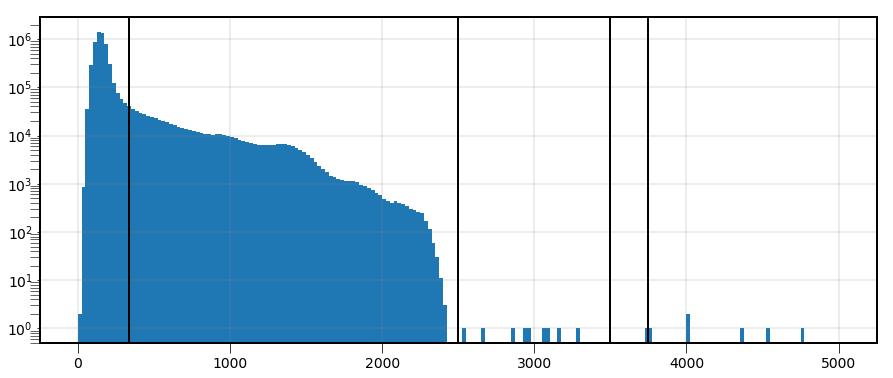

In [253]:
plt.figure(figsize=(15,6))
_ = plt.hist(image.flatten(), np.linspace(0, 5000, 201))
#_ = plt.hist(image.flatten(), np.linspace(0, 500, 201))
#_ = plt.hist(image.flatten(), np.linspace(0, 5000, 201))

plt.yscale('log')
plt.axvline(image.mean()*1.5, 0, 1, color = 'k')
plt.axvline(3500, 0, 1, color = 'k')
plt.axvline(2500, 0, 1, color = 'k')
plt.axvline(3750, 0, 1, color = 'k')

print image.mean()

In [254]:
noise = image.mean()*1.5
if wl == '405':
    nmax  = 3000.
if wl =='266':
    nmax = 2500.
if wl == '375':
    nmax = 3750.
    
image[image>nmax] = noise
smooth =  ndimage.gaussian_filter(image, 6)

In [255]:
log_image = deepcopy(image)
log_image[image==0] = image[image>0].min()
log_image = np.log10(log_image)
lsmooth = ndimage.gaussian_filter(log_image,6)

### Plots in intensity

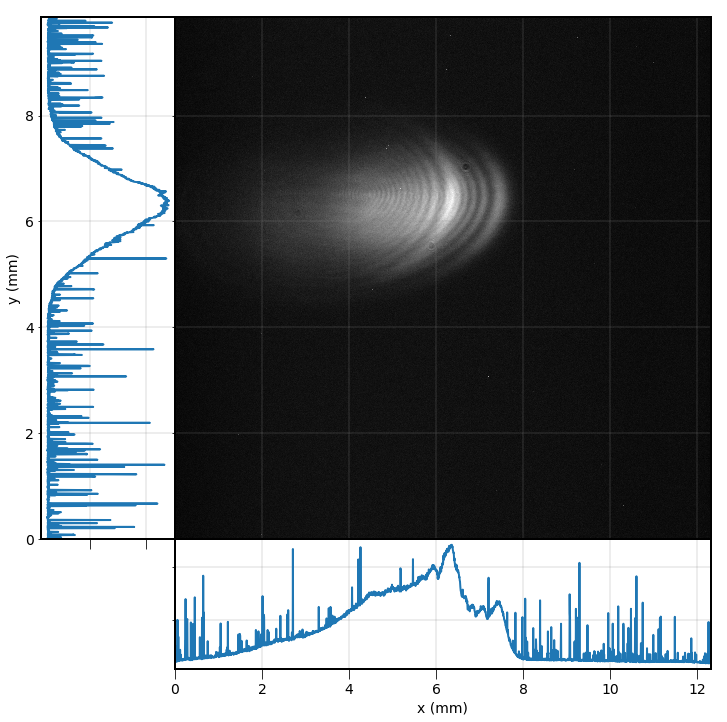

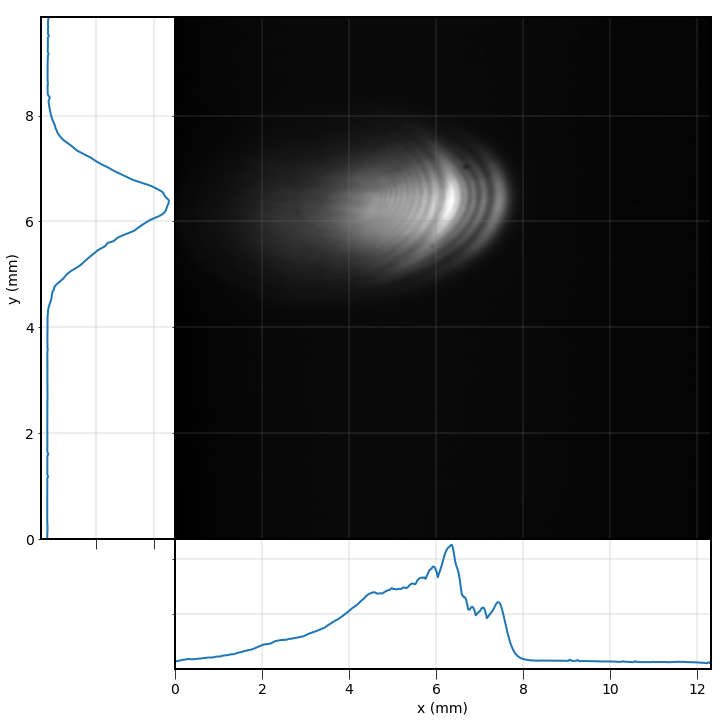

In [256]:
f = profile2D(image, xaxis, yaxis)
f.savefig(os.path.join(indir, wl+'_intensity.png'), dpi=300)
f = profile2D(smooth, xaxis, yaxis)
f.savefig(os.path.join(indir, wl+'_intensity_smooth.png'), dpi=300)

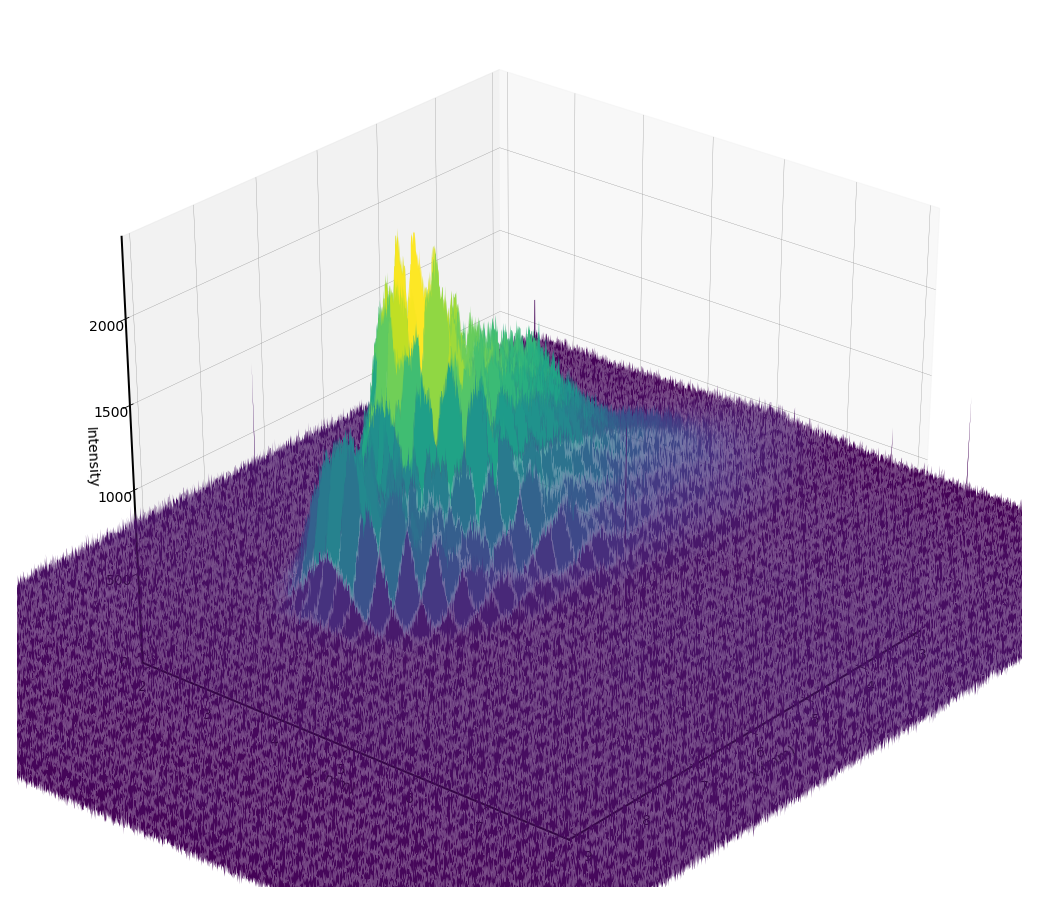

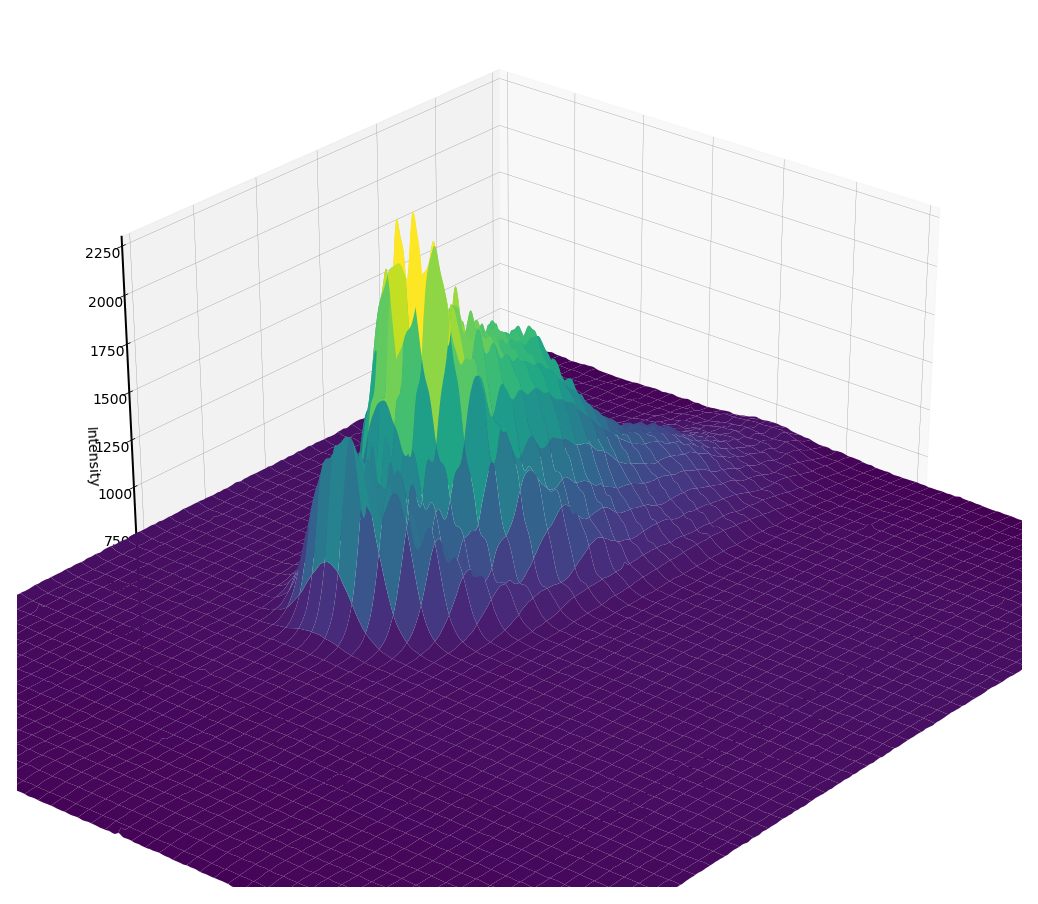

In [257]:
f = profile3D(image, xaxis, yaxis)
f.savefig(os.path.join(indir, wl+'_intensity_3D.png'), dpi=300)
f = profile3D(smooth, xaxis, yaxis)
f.savefig(os.path.join(indir, wl+'_intensity_3D_smooth.png'), dpi=300)


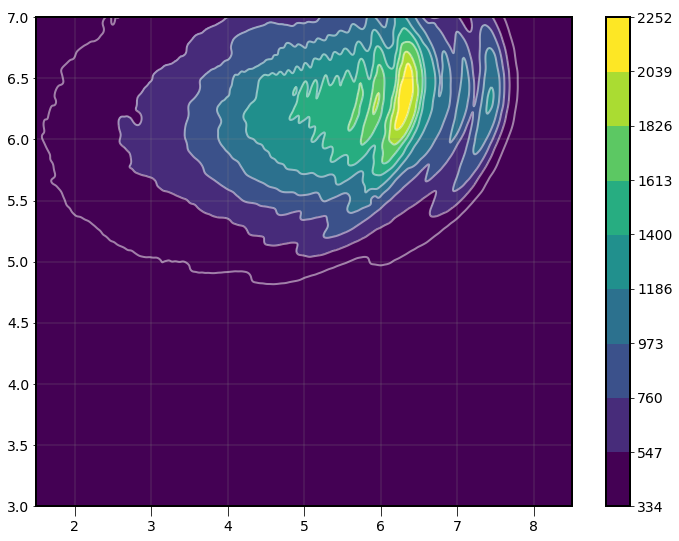

In [258]:
#f = profileContour(image, xaxis, yaxis)
f = profileContour(smooth, xaxis, yaxis)
f.savefig(os.path.join(indir, wl+'_contours_smooth.png'), dpi=300)


### Doing it in log(I)

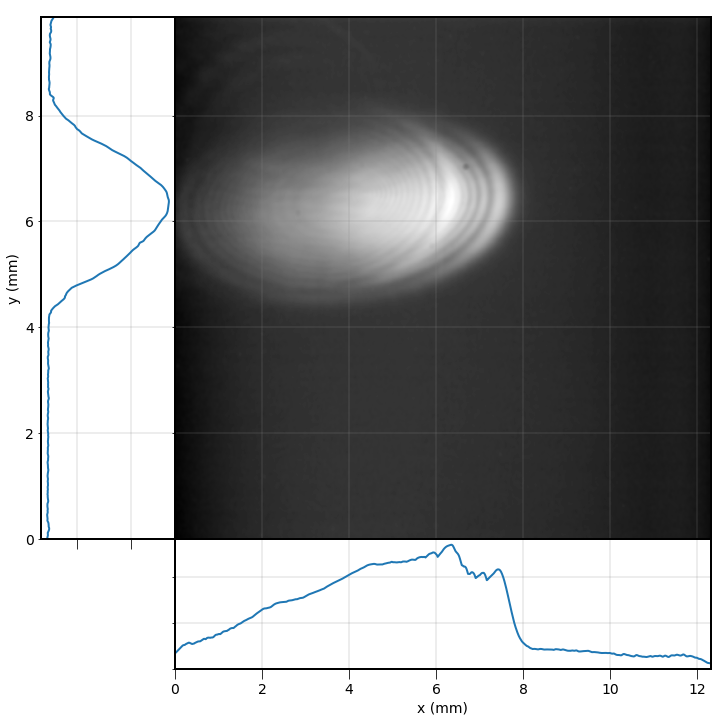

In [259]:
#_ = profile2D(log_image, xaxis, yaxis)
f = profile2D(lsmooth, xaxis, yaxis)
f.savefig(os.path.join(indir, wl+'_logi_smooth.png'), dpi=300)


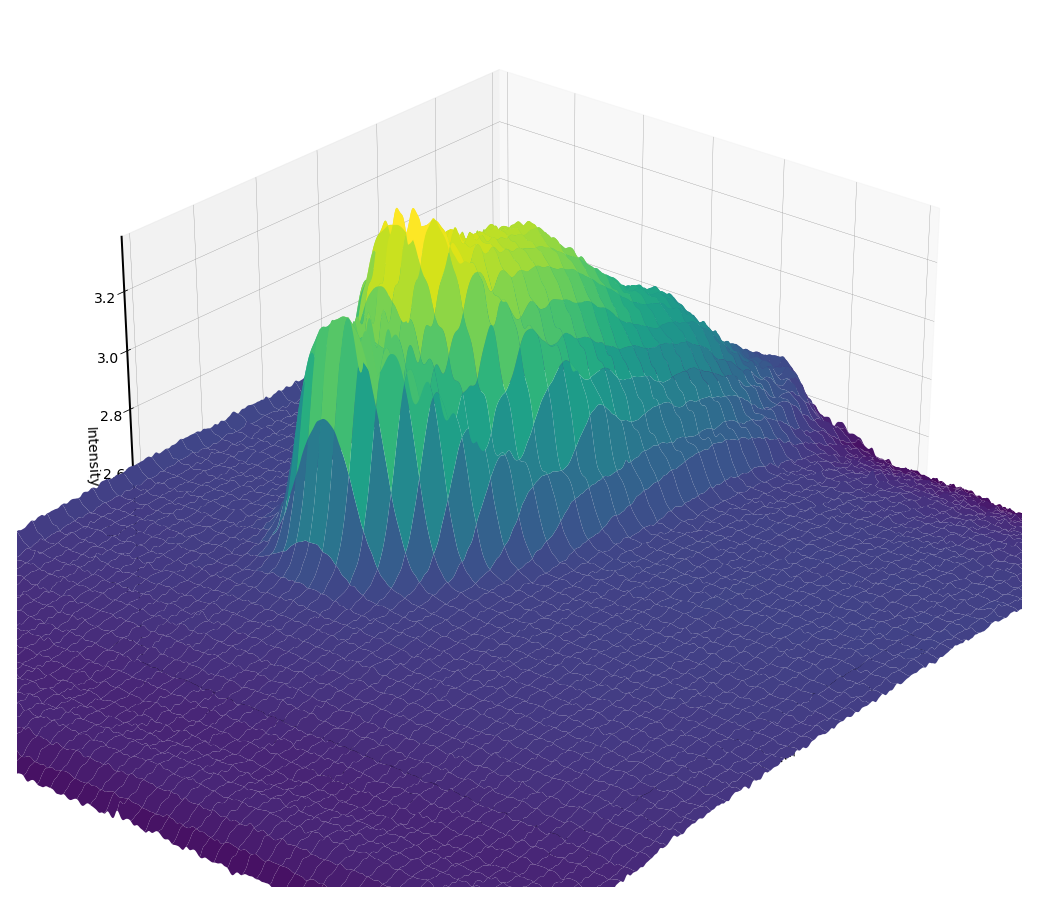

In [260]:
#_ = profile3D(log_image, xaxis, yaxis)
f = profile3D(lsmooth, xaxis, yaxis)
f.savefig(os.path.join(indir, wl+'_logi_3D_smooth.png'), dpi=300)
